In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier as XGBC
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

import torch
import torch.nn as nn
from torch.optim import SGD #gradient descent optimizer
from sklearn.preprocessing import OneHotEncoder
# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

from sklearn.svm import SVC

# Tools in sklearn to select best model
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

# Decision tree classifier in sklearn
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
from sklearn.metrics import roc_auc_score, average_precision_score

# We use f1 score to test model performance
from sklearn.metrics import f1_score

# Import matplotlib.pyplot to visualize tree models
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import random

print(os.getcwd())

os.chdir("C:/Users/zepingy/OneDrive - Crawfurd Hospital/BMI5111/SPH6004")

#os.chdir("C:/Users/yapze/OneDrive - Crawfurd Hospital/BMI5111/SPH6004")
print(os.getcwd())

In [4]:
df = pd.read_csv("sph6004_assignment1_data.csv")

In [5]:
df.head()

,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,36570066,3,F,79.953141,BLACK/AFRICAN AMERICAN,96.0,104.0,100.083333,103.0,126.0,...,NaN,236.0,318.0,15.0,6.0,5.0,4.0,0.0,157.0,110.0
1,39307659,0,F,78.194169,WHITE - RUSSIAN,72.0,134.0,97.263158,97.0,127.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,82.0
2,38743306,2,F,65.602396,WHITE,60.0,97.0,84.166667,95.0,143.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,62.1
3,32339865,2,F,64.906629,UNKNOWN,59.0,87.0,71.461538,113.0,150.0,...,NaN,NaN,NaN,15.0,1.0,0.0,1.0,1.0,170.0,113.1
4,35526987,2,M,57.438861,WHITE,57.0,100.0,82.387097,81.0,127.0,...,NaN,NaN,NaN,15.0,NaN,0.0,1.0,1.0,178.0,97.4


I will use logistic regression model first as a simplified model to test whether the code can run properly. Since logistic regression only has binary output (yes/no), I will have to convert the AKI (output) column to 0 = No, 1/2/3 = Yes

In [6]:
df['AKI_Binary'] = df['aki'].apply(lambda x: 1 if x > 0 else 0)   #convert binary

In [7]:


value_counts_AKI_B = df['AKI_Binary'].value_counts()
value_counts_AKI = df['aki'].value_counts()

print(value_counts_AKI_B)
print(value_counts_AKI)

#Based on outcomes, data is not really imbalance so no processing required

1    34060
0    16860
Name: AKI_Binary, dtype: int64
0    16860
2    16288
1     9838
3     7934
Name: aki, dtype: int64


In [8]:
df.describe()

,id,aki,admission_age,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,...,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit,AKI_Binary
count,5.092000e+04,50920.000000,50920.000000,50841.000000,50841.000000,50841.000000,50823.000000,50823.000000,50823.000000,50823.000000,...,14689.000000,14689.000000,50685.000000,50266.000000,50407.000000,50542.000000,50685.000000,25011.000000,49900.000000,50920.000000
mean,3.498391e+07,1.300393,64.942008,69.902996,102.494951,84.266427,93.250232,148.234674,119.102894,47.337019,...,470.911158,582.595412,13.702141,5.167549,3.385066,3.124471,0.205643,169.628199,81.537677,0.668892
std,2.893873e+06,1.088128,17.278264,15.141810,20.481365,15.726366,17.550959,22.737214,16.375046,11.743710,...,997.308493,1461.193067,2.649433,1.665102,2.090396,1.106433,0.404174,10.683969,36.206192,0.470616
min,3.000015e+07,0.000000,18.002527,1.000000,36.000000,28.500000,0.108000,34.000000,32.000000,1.000000,...,31.000000,31.000000,3.000000,1.000000,0.000000,1.000000,0.000000,122.000000,1.000000,0.000000
25%,3.246663e+07,0.000000,54.503884,60.000000,88.000000,73.229167,83.000000,132.000000,107.470588,40.000000,...,195.000000,203.000000,14.000000,5.000000,1.000000,3.000000,0.000000,163.000000,65.900000,0.000000
50%,3.498649e+07,1.000000,66.713334,69.000000,100.000000,82.769231,92.000000,146.000000,116.925926,47.000000,...,262.000000,277.000000,15.000000,6.000000,5.000000,4.000000,0.000000,170.000000,78.400000,1.000000
75%,3.748413e+07,2.000000,78.151289,79.000000,114.000000,94.080000,103.000000,161.000000,129.093074,54.000000,...,396.000000,437.000000,15.000000,6.000000,5.000000,4.000000,0.000000,178.000000,93.000000,1.000000
max,3.999981e+07,3.000000,102.865603,167.000000,280.000000,174.740741,195.000000,357.000000,215.857143,113.000000,...,22890.000000,63325.000000,15.000000,6.000000,5.000000,4.000000,1.000000,226.000000,5864.000000,1.000000


In [9]:
num_unique_values = df.nunique(axis=0)
print(num_unique_values)

id               50920
aki                  4
gender               2
admission_age    50695
race                33
                 ...  
gcs_eyes             4
gcs_unable           2
height              98
weight_admit      1506
AKI_Binary           2
Length: 163, dtype: int64


In [10]:
df['gender_new'] = df['gender'].apply(lambda x: 0 if x == 'F' else 1)  # F = 0 , M = 1
print(df['gender_new'])

0        0
1        0
2        0
3        0
4        1
        ..
50915    1
50916    0
50917    0
50918    0
50919    1
Name: gender_new, Length: 50920, dtype: int64


In [11]:
mapping = {
    "HISPANIC OR LATINO": "HISPANIC/LATINO",
    "HISPANIC/LATINO - PUERTO RICAN": "HISPANIC/LATINO",
    "HISPANIC/LATINO - SALVADORAN": "HISPANIC/LATINO",
    "HISPANIC/LATINO - DOMINICAN": "HISPANIC/LATINO",
    "HISPANIC/LATINO - MEXICAN": "HISPANIC/LATINO",
    "HISPANIC/LATINO - GUATEMALAN": "HISPANIC/LATINO",
    "HISPANIC/LATINO - HONDURAN": "HISPANIC/LATINO",
    "HISPANIC/LATINO - CUBAN": "HISPANIC/LATINO",
    "HISPANIC/LATINO - CENTRAL AMERICAN": "HISPANIC/LATINO",
    "HISPANIC/LATINO - COLUMBIAN": "HISPANIC/LATINO",
    "WHITE - BRAZILIAN": "WHITE",
    "WHITE - EASTERN EUROPEAN": "WHITE",
    "WHITE - OTHER EUROPEAN": "WHITE",
    "WHITE - RUSSIAN": "WHITE",
    "PATIENT DECLINED TO ANSWER":"UNKNOWN",
    "UNABLE TO OBTAIN":"UNKNOWN",
    "PATIENT DECLINED TO ANSWER":"UNKNOWN",   
}

df["race"] = df["race"].map(mapping).fillna(df["race"])

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["race_new"] = label_encoder.fit_transform(df["race"])

print(df['race_new'])

0         7
1        17
2        17
3        16
4        17
         ..
50915    17
50916    17
50917    17
50918    14
50919    16
Name: race_new, Length: 50920, dtype: int32


In [13]:
rows_with_missing_data = df[df.isnull().any(axis=1)]
num_rows_with_missing_data = len(rows_with_missing_data)

print(f'Number of rows with at least one missing data: {num_rows_with_missing_data}')

Number of rows with at least one missing data: 50920


All rows in the data set contains at least one missing value. Hence, we will proceed with analysing the relevant columns for data with > 50% missing data, combine with domain expert knowledge to see if dropping the data is suitable for our analysis. This will also serve as a non-data driven feature selection method.

In [14]:
missing_percentage = df.isnull().mean() * 100

columns_with_high_missing = missing_percentage[missing_percentage > 50].index.tolist()

# Display the list of columns with more than 50% missing values
print("Columns with more than 50% missing values:", columns_with_high_missing)

Columns with more than 50% missing values: ['so2_min', 'so2_max', 'aado2_min', 'aado2_max', 'aado2_calc_min', 'aado2_calc_max', 'pao2fio2ratio_min', 'pao2fio2ratio_max', 'bicarbonate_min', 'bicarbonate_max', 'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'carboxyhemoglobin_min', 'carboxyhemoglobin_max', 'methemoglobin_min', 'methemoglobin_max', 'temperature_min.1', 'temperature_max.1', 'chloride_min', 'chloride_max', 'calcium_min', 'calcium_max', 'glucose_min.1', 'glucose_max.1', 'potassium_min', 'potassium_max', 'sodium_min', 'sodium_max', 'albumin_min', 'albumin_max', 'globulin_min', 'globulin_max', 'total_protein_min', 'total_protein_max', 'atyps_min', 'atyps_max', 'bands_min', 'bands_max', 'imm_granulocytes_min', 'imm_granulocytes_max', 'metas_min', 'metas_max', 'nrbc_min', 'nrbc_max', 'd_dimer_min', 'd_dimer_max', 'fibrinogen_min', 'fibrinogen_max', 'thrombin_min', 'thrombin_max', 'alt_min', 'alt_max', 'alp_min', 'alp_max', 'ast_min', 'ast_max', 'amylase_m

In [15]:
from sklearn.impute import SimpleImputer

df.replace('NA', pd.NA, inplace=True)

non_numeric_columns = df.select_dtypes(exclude=['number']).columns.tolist()

# Impute missing values for numeric columns using SimpleImputer with strategy='mean'
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
imputer = SimpleImputer(strategy='mean')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: ['gender', 'race']


In [16]:
from scipy.stats import zscore
# Calculate Z-scores
z_scores = zscore(df[numeric_columns])


threshold =5


outliers_mask = (abs(z_scores) > threshold).any(axis=1)

# Drop rows with outliers
df_cleaned = df[~outliers_mask]

# Display the DataFrame without outliers
print(df_cleaned)

               id  aki gender  admission_age     race  heart_rate_min  \
1      39307659.0  0.0      F      78.194169    WHITE            72.0   
2      38743306.0  2.0      F      65.602396    WHITE            60.0   
3      32339865.0  2.0      F      64.906629  UNKNOWN            59.0   
5      36121759.0  3.0      M      62.002429    WHITE            78.0   
7      38941409.0  0.0      F      44.317598    ASIAN            60.0   
...           ...  ...    ...            ...      ...             ...   
50910  34806537.0  1.0      M      65.278904    WHITE            74.0   
50912  34638264.0  1.0      F      85.491796    WHITE            83.0   
50913  31701922.0  0.0      M      34.707364    WHITE            86.0   
50914  37061810.0  2.0      M      71.189233    WHITE            57.0   
50915  33431859.0  0.0      M      66.174854    WHITE            46.0   

       heart_rate_max  heart_rate_mean  sbp_min  sbp_max  ...  gcs_min  \
1               134.0        97.263158     97.0  

In [17]:
df_cleaned.describe()

,id,aki,admission_age,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,...,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit,AKI_Binary,gender_new,race_new
count,3.913000e+04,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,...,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000,39130.000000
mean,3.497780e+07,1.219141,65.111142,69.106842,100.910855,83.081074,94.606266,148.301699,119.978524,47.861437,...,13.776429,5.275617,3.539258,3.191238,0.182166,169.698878,81.449017,0.646512,0.558600,15.188321
std,2.894494e+06,1.061741,17.045262,14.241262,19.481427,14.913899,16.532100,21.661423,15.940998,11.393147,...,2.525815,1.562441,2.020425,1.061870,0.385271,7.307527,22.338429,0.478059,0.496561,3.767846
min,3.000015e+07,0.000000,18.002527,3.000000,36.000000,28.500000,6.000000,46.000000,46.000000,1.000000,...,3.000000,1.000000,0.000000,1.000000,0.000000,135.000000,1.000000,0.000000,0.000000,0.000000
25%,3.246442e+07,0.000000,54.929186,60.000000,87.000000,72.684211,84.000000,133.000000,108.357143,41.000000,...,14.000000,6.000000,1.000000,3.000000,0.000000,169.628199,66.500000,0.000000,0.000000,16.000000
50%,3.497331e+07,1.000000,66.846727,68.000000,99.000000,81.777778,93.000000,146.000000,117.798438,47.000000,...,15.000000,6.000000,5.000000,4.000000,0.000000,169.628199,79.300000,1.000000,1.000000,17.000000
75%,3.747480e+07,2.000000,78.049843,78.000000,112.000000,92.418683,104.000000,161.000000,129.777778,54.000000,...,15.000000,6.000000,5.000000,4.000000,0.000000,170.000000,93.000000,1.000000,1.000000,17.000000
max,3.999981e+07,3.000000,102.865603,145.000000,204.000000,154.576923,180.000000,260.000000,197.600000,105.000000,...,15.000000,6.000000,5.000000,4.000000,1.000000,203.000000,254.000000,1.000000,1.000000,17.000000


In [18]:

numeric_columns_to_standardize = df_cleaned.select_dtypes(include='number').columns.difference(['aki', 'AKI_Binary'])


df_cleaned.loc[:, numeric_columns_to_standardize] = (
    df_cleaned.loc[:, numeric_columns_to_standardize] - df_cleaned.loc[:, numeric_columns_to_standardize].mean()
) / df_cleaned.loc[:, numeric_columns_to_standardize].std()

C:\Users\zepingy\AppData\Local\Temp\ipykernel_17932\404299400.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, numeric_columns_to_standardize] = (


In [19]:
df_cleaned.head()

,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit,AKI_Binary,gender_new,race_new
1,1.495897,0.0,F,0.767546,WHITE,0.203153,1.698497,0.950931,0.144793,-0.983393,...,0.484426,0.463623,0.722988,0.761640,-0.472824,-0.009672,0.024665,0.0,-1.124937,0.480826
2,1.300922,2.0,F,0.028821,WHITE,-0.639469,-0.200748,0.072791,0.023816,-0.244753,...,0.484426,0.463623,0.722988,0.761640,-0.472824,-0.009672,-0.866176,1.0,-1.124937,0.480826
3,-0.911362,2.0,F,-0.011998,UNKNOWN,-0.709687,-0.714057,-0.779108,1.112607,0.078402,...,0.484426,-2.736498,-1.751739,-2.063566,2.122748,0.041207,1.416885,1.0,-1.124937,0.215423
5,0.395220,3.0,M,-0.182380,WHITE,0.624464,0.209900,0.463925,-0.883509,0.263062,...,0.484426,0.463623,0.722988,0.761640,-0.472824,-0.009672,2.527079,1.0,0.888916,0.480826
7,1.369363,0.0,F,-1.219902,ASIAN,-0.639469,-1.073374,-1.202785,0.265770,-0.198588,...,0.484426,0.463623,0.722988,0.761640,-0.472824,-0.009672,-1.210874,0.0,-1.124937,-3.765632


In [20]:
#Spliting data


columns_to_exclude = ['gender', 'aki','race','id','AKI_Binary'] + columns_with_high_missing


X_df = df_cleaned.drop(columns=columns_to_exclude)
 
y_df = df_cleaned['AKI_Binary']


In [21]:

X = torch.tensor(X_df.to_numpy(),dtype=torch.float32)
m,n = X.shape
y = torch.tensor(y_df.to_numpy(),dtype=torch.float32).reshape(m,1)


cases = ['train','test']
case_list = np.random.choice(cases,size=X.shape[0],replace=True,p=[0.7,0.3])
X_train = X[case_list=='train']
X_test = X[case_list=='test']
y_train = y[case_list=='train']
y_test = y[case_list=='test']

Logistic Regression

In [ ]:
h = torch.nn.Linear(
    in_features=n,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

# Logistic model is linear+sigmoid
f = torch.nn.Sequential(
    h,
    sigma
)

J_BCE = torch.nn.BCELoss()

GD_optimizer = torch.optim.Adam(lr=0.1,params=f.parameters())

nIter = 3000
printInterval = 500

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred = f(X_train)
    loss = J_BCE(pred,y_train)
    loss.backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test = f(X_test)

threshold = 0.5  # You can adjust this threshold based on your specific needs

y_pred_binary = (pred_test >= threshold).numpy().astype(int)

auroc = roc_auc_score(y_test,pred_test)
ap = average_precision_score(y_test,pred_test)
f1 = f1_score(y_test, y_pred_binary)
print('On test dataset: AUROC {:.3f}, AP {:.3f}, F1 {:.3f}'.format(auroc,ap, f1))

In [ ]:


weight = h.weight.detach().squeeze().clone()

In [ ]:
h_L2 = torch.nn.Linear(
    in_features=n,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

# Logistic model is linear+sigmoid
f_L2 = torch.nn.Sequential(
    h_L2,
    sigma
)

J_BCE = torch.nn.BCELoss()

# PyTorch optimizer support L2 regularization by
# setting the weight_decay parameter, which corresponds to
# the regularization strength.
GD_optimizer = torch.optim.Adam(lr=0.1,params=f_L2.parameters(),weight_decay=0.05)

nIter = 1000
printInterval = 250

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred = f_L2(X_train)
    loss = J_BCE(pred,y_train)
    loss.backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test = f_L2(X_test)

threshold = 0.5  # You can adjust this threshold based on your specific needs

y_pred_binary = (pred_test >= threshold).numpy().astype(int)

auroc = roc_auc_score(y_test,pred_test)
ap = average_precision_score(y_test,pred_test)
f1 = f1_score(y_test, y_pred_binary)
print('On test dataset: AUROC {:.3f}, AP {:.3f}, F1 {:.3f}'.format(auroc,ap, f1))

In [ ]:
weight_L2 = h_L2.weight.detach().squeeze().clone()

In [ ]:
h_L1 = torch.nn.Linear(
    in_features=n,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

# Logistic model is linear+sigmoid
f_L1 = torch.nn.Sequential(
    h_L1,
    sigma
)

J_BCE = torch.nn.BCELoss()

GD_optimizer = torch.optim.Adam(lr=0.1,params=f_L1.parameters())

# Define L_1 regularization
def L1_reg(model,lbd):
    result = torch.tensor(0)
    for param in model.parameters(): # iterate over all parameters of our model
        result = result + param.abs().sum()

    return lbd*result


nIter = 1000
printInterval = 250
lbd = 0.03 # L1 reg strength

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred = f_L1(X_train)
    loss = J_BCE(pred,y_train)
    (loss+L1_reg(f_L1,lbd)).backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test = f_L1(X_test)

threshold = 0.5  # You can adjust this threshold based on your specific needs

y_pred_binary = (pred_test >= threshold).numpy().astype(int)

auroc = roc_auc_score(y_test,pred_test)
ap = average_precision_score(y_test,pred_test)
f1 = f1_score(y_test, y_pred_binary)
print('On test dataset: AUROC {:.3f}, AP {:.3f}, F1 {:.3f}'.format(auroc,ap, f1))

In [ ]:
weight_L1 = h_L1.weight.detach().squeeze().clone()

In [ ]:
weight_df = pd.DataFrame(
    {
        'vanilla':weight,
        'L2':weight_L2,
        'L1':weight_L1
    }
).melt(id_vars=[],value_vars=['vanilla','L2','L1'])
weight_df

In [ ]:
fig = px.box(
    weight_df,
    y='value',
    facet_col='variable',
    color='variable',
    points='all',
    title='Logistic Regression Weights Distributions'
)
fig.update_yaxes(
    matches=None,
    showticklabels=True
)
fig.update_traces(jitter=0.5)

In [ ]:
coefs = h.weight.data.cpu().numpy()  # Extract weights as a numpy array

if coefs.ndim > 1:
    coefs = coefs.flatten()
top_three = np.argpartition(coefs, -10)[-10:]
top_three_sorted=top_three[np.argsort(coefs[top_three])]

top_features = X_df.columns[top_three_sorted]


for top_features, coefs in zip(top_features, coefs):
    print(f"Feature: {top_features}, Weights: {coefs:.4f}")

In [ ]:
coefs = h_L2.weight.data.cpu().numpy()  # Extract weights as a numpy array


if coefs.ndim > 1:
    coefs = coefs.flatten()
top_three = np.argpartition(coefs, -10)[-10:]
top_three_sorted=top_three[np.argsort(coefs[top_three])]

top_features = X_df.columns[top_three_sorted]

for top_features, coefs in zip(top_features, coefs):
    print(f"Feature: {top_features}, Weights: {coefs:.4f}")

In [ ]:
coefs = h_L1.weight.data.cpu().numpy() # Extract weights

if coefs.ndim > 1:
    coefs = coefs.flatten()


top_10_abs_indices = np.argpartition(np.abs(coefs), -10)[-10:]  # Use abs values for sorting

# Sort these indices based on actual coefficients
top_10_sorted_indices = top_10_abs_indices[np.argsort(coefs[top_10_abs_indices])]

# Retrieve corresponding feature names
top_features = X_df.columns[top_10_sorted_indices]

# Print feature names and weights in sorted order
for feature, coef in zip(top_features, coefs[top_10_sorted_indices]):
    print(f"Feature: {feature}, Weight: {coef:.4f}")

Decision Tree - Random Forst / Gradient Boost

In [ ]:
y_df = df_cleaned['aki']

X = torch.tensor(X_df.to_numpy(),dtype=torch.float32)
m,n = X.shape
y = torch.tensor(y_df.to_numpy(),dtype=torch.float32).reshape(m,1)


cases = ['train','test']
case_list = np.random.choice(cases,size=X.shape[0],replace=True,p=[0.7,0.3])
X_train = X[case_list=='train']
X_test = X[case_list=='test']
y_train = y[case_list=='train']
y_test = y[case_list=='test']

In [ ]:
Xy = pd.concat([X_df, y_df], axis=1)

Xy['label'] = np.where(y_df.to_numpy() == 0, 'Nil',
                       np.where(y_df.to_numpy() == 1, 'Stage_1',
                                np.where(y_df.to_numpy() == 2, 'Stage_2', 
                                         'Stage_3')))

Xy.info()

In [ ]:
TreeModel = DTC(criterion='entropy',max_depth=3,random_state=15)
TreeModel.fit(X_train,y_train)

In [ ]:
# Splitting rules can be visualized by using plot_tree in sklearn
plt.figure(figsize=(14,10))
plot_tree(
    TreeModel,
    filled=True,
    feature_names=list(df.columns),
    class_names=['Nil', 'Stage_1', 'Stage_2', 'Stage_3']
)
plt.show()

In [ ]:
# The `max_depth` parameter is important for decision tree.
# We use `GridSearchCV` to select the best `max_depth`.

parameters = {'max_depth':np.arange(start=1,stop=10,step=1)}
parameters

In [ ]:
stratifiedCV = StratifiedKFold(n_splits=8)
TreeModel = DTC(criterion='entropy')
BestTree = GridSearchCV(
    TreeModel,
    param_grid=parameters,
    scoring='f1_weighted',
    cv=stratifiedCV
)
BestTree.fit(X_train,y_train)

In [ ]:
BestTree.best_estimator_

In [ ]:
BestTree.best_score_

In [ ]:
y_pred = BestTree.best_estimator_.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 score on test set: {:.4f}'.format(f1))
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

In [ ]:
y_test_np = y_test.numpy()


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
best_estimator = BestTree.best_estimator_
if isinstance(BestTree.best_estimator_, DecisionTreeClassifier):
   
    from sklearn.tree import plot_tree
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    plot_tree(best_estimator, filled=True, feature_names=list(df.columns))
    plt.show()


elif isinstance(best_estimator, RandomForestClassifier):
    # You can visualize individual trees in the forest
    from sklearn.tree import plot_tree
    import matplotlib.pyplot as plt

    # Accessing individual trees in the forest
    for i, tree_in_forest in enumerate(best_estimator.estimators_):
        plt.figure(figsize=(10, 8))
        plot_tree(tree_in_forest, filled=True, feature_names=your_feature_names)
        plt.title(f'Tree {i+1} in the Random Forest')
        plt.show()


In [ ]:
y_train_reshaped = y_train.ravel()

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=1000, max_depth =9, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train_reshaped)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Test Accuracy:", accuracy)
print("F1 score:", f1)

In [ ]:
feature_names = pd.DataFrame(X_train, columns=list(X_df.columns)).columns

In [ ]:
feature_importances = rf_classifier.feature_importances_

In [ ]:
top10_indices = feature_importances.argsort()[-10:][::-1]

In [ ]:
plt.barh(range(len(top10_indices)), feature_importances[top10_indices], align='center', height=0.5)
plt.yticks(range(len(top10_indices)), feature_names[top10_indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Random Forest Feature Importance')
plt.show()

Gradient Boost Tree

In [ ]:
print(len((X_train)[0]))

In [ ]:
print(X_train)

In [22]:
parameters = {
    'n_estimators':np.arange(start=30,stop=60,step=2),
    'max_depth':np.arange(start=3,stop=7,step=1),
    'learning_rate':np.arange(start=0.2,stop=0.6,step=0.1)
}

parameters

{'n_estimators': array([30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]),
 'max_depth': array([3, 4, 5, 6]),
 'learning_rate': array([0.2, 0.3, 0.4, 0.5])}

In [23]:
X_scaled_df = pd.DataFrame(X_train, columns=list(X_df.columns))  #for detailing the type of features under importance

In [24]:
print(X_scaled_df)

       admission_age  heart_rate_min  heart_rate_max  heart_rate_mean  \
0           0.767546        0.203153        1.698497         0.950931   
1           0.028821       -0.639469       -0.200748         0.072791   
2          -0.182380        0.624464        0.209900         0.463925   
3          -1.219902       -0.639469       -1.073374        -1.202785   
4           0.206760       -2.535368       -2.664633        -2.786834   
...              ...             ...             ...              ...   
27383      -0.927169       -0.569250       -0.098086        -0.627397   
27384       0.115277        0.764901        0.261231         0.506273   
27385       0.009842        0.343590       -0.149417         0.076192   
27386       1.195679        0.975557        2.160475         0.896292   
27387      -1.783708        1.186212        1.287849         1.216965   

        sbp_min   sbp_max  sbp_mean   dbp_min   dbp_max  dbp_mean  ...  \
0      0.144793 -0.983393 -0.636421  0.714338  0.

In [25]:
stratifiedCV = StratifiedKFold(n_splits=8)
# XGBC: XGBoost classifier
XGBoostModel = XGBC()
BestXGBoost = GridSearchCV(
    XGBoostModel,
    param_grid=parameters,
    scoring='f1_weighted',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1 
)



BestXGBoost.fit(X_scaled_df, y_train)

Fitting 8 folds for each of 240 candidates, totalling 1920 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.2, 0.3, 0.4, 0.5]),
                         'max_depth': array([3, 4, 5, 6]),
                         'n_estimators': array([30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58])},
             scoring='f1_weighted', verbose=1)

In [26]:
BestXGBoost.best_params_

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 54}

In [27]:
BestXGBoost.best_score_

0.7124915304486705

In [28]:
BestXGBoost.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=54, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

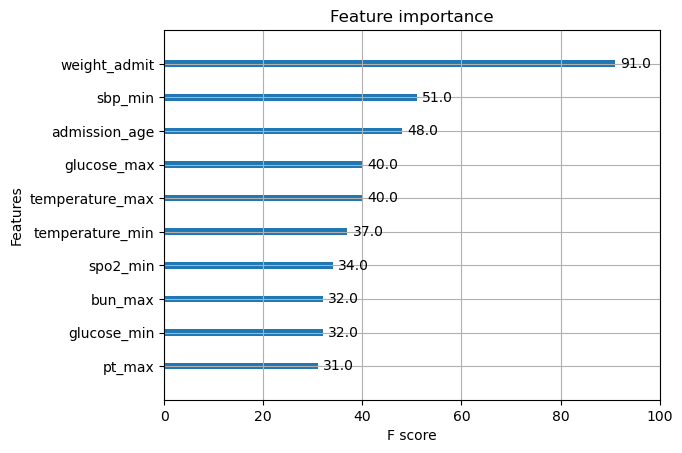

In [29]:
from xgboost import plot_importance

plot_importance(BestXGBoost.best_estimator_, max_num_features=10) # top 10 most important features
plt.show()

In [30]:
X_scaled_test_df = pd.DataFrame(X_test, columns=list(X_df.columns))

y_pred = BestXGBoost.predict(X_scaled_test_df)


print('F1 score on test set: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


F1 score on test set: 0.7167
0.7277295179696814


Support Vector Machine

In [31]:
y_df = df_cleaned['aki']

X = torch.tensor(X_df.to_numpy(),dtype=torch.float32)
m,n = X.shape
y = torch.tensor(y_df.to_numpy(),dtype=torch.float32).reshape(m,1)


cases = ['train','test']
case_list = np.random.choice(cases,size=X.shape[0],replace=True,p=[0.7,0.3])
X_train = X[case_list=='train']
X_test = X[case_list=='test']
y_train = y[case_list=='train']
y_test = y[case_list=='test']
y_train_reshaped = y_train.ravel()
print(y_train)

tensor([[0.],
        [2.],
        [3.],
        ...,
        [0.],
        [2.],
        [0.]])


In [ ]:
print(len((X_train)[0]))

In [ ]:
parameters = {
    'C': [0.1, 1, 10],         # Regularization parameter
    'kernel': ['linear'],   # Kernel type
    'gamma': ['scale', 'auto']     # Kernel coefficient (for 'rbf' kernel)
}


In [ ]:
# 'C': strength of L2 regularization on linear SVM. Larger 'C' --> smaller regularization.



stratifiedCV = StratifiedKFold(n_splits=5)
SVCModel = SVC()
BestSVC = GridSearchCV(
    SVCModel,
    param_grid=parameters,
    scoring='f1_weighted',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVC.fit(X_train, y_train_reshaped)


In [ ]:
BestSVC.best_estimator_

In [ ]:
BestSVC.best_score_

In [ ]:
X_scaled_test_df = pd.DataFrame(X_test, columns=list(X_df.columns))

y_pred = BestSVC.predict(X_scaled_test_df)

print('F1 score on test set: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['input1', 'input2']
svm = svm.SVC(kernel='linear')
svm.fit(X, Y)
f_importances(svm.coef_, features_names)

In [ ]:
coefs = h_L1.weight.data.cpu().numpy() # Extract weights

if coefs.ndim > 1:
    coefs = coefs.flatten()


top_30_abs_indices = np.argpartition(np.abs(coefs), -30)[-30:] 
# Sort these indices based on actual coefficients
top_30_sorted_indices = top_30_abs_indices[np.argsort(coefs[top_30_abs_indices])]

# Retrieve corresponding feature names
top_features30 = X_df.columns[top_30_sorted_indices]

# Print feature names and weights in sorted order
for feature, coef in zip(top_features30, coefs[top_30_sorted_indices]):
    print(f"Feature: {feature}, Weight: {coef:.4f}")

In [ ]:
top_features_log_df = X_df[top_features30]
top_features_log_df['aki'] =  df_cleaned.loc[:, 'aki'].values
top_features_log_df.head(100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    top_features_log_df.drop('aki', axis=1),
    top_features_log_df['aki'],
    test_size=0.3,
    random_state=42
)

In [ ]:
# 'C': strength of L2 regularization on linear SVM. Larger 'C' --> smaller regularization.

parameters = {
    'C': [1,5,7]
}

stratifiedCV = StratifiedKFold(n_splits=5)
SVCModel = SVC(kernel='rbf')
BestSVC = GridSearchCV(
    SVCModel,
    param_grid=parameters,
    scoring='f1_weighted',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVC.fit(X_train, y_train)


In [ ]:
BestSVC.best_estimator_

In [ ]:
BestSVC.best_score_

In [ ]:
y_pred = BestSVC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('F1 score on test set: {:.4f}'.format(f1_score(y_test,y_pred, average ='weighted')))
print(accuracy)
pd.crosstab(y_test,y_pred)

In [ ]:
coefs = h_L2.weight.data.cpu().numpy()  # Extract weights as a numpy array

# Flatten the array if it has multiple dimensions (e.g., for multiple output features)
if coefs.ndim > 1:
    coefs = coefs.flatten()
top_three_L2 = np.argpartition(coefs, -30)[-30:]
top_three_L2_sorted=top_three_L2[np.argsort(coefs[top_three_L2])]

top_features_L2 = X_df.columns[top_three_L2_sorted]


for top_features, coefs in zip(top_features_L2, coefs):
    print(f"Feature: {top_features_L2}, Weights: {coefs:.4f}")

In [ ]:
top_features_logL2_df = X_df[top_features_L2]
top_features_logL2_df['aki'] =  df_cleaned.loc[:, 'aki'].values
top_features_logL2_df.head()

In [ ]:
X_train_L2, X_test_L2, y_train_L2, y_test_L2 = train_test_split(
    top_features_logL2_df.drop('aki', axis=1),
    top_features_logL2_df['aki'],
    test_size=0.3,
    random_state=42
)

In [ ]:


parameters = {
    'C': [0.5,1,5,7]
}

stratifiedCV = StratifiedKFold(n_splits=5)
SVCModel = SVC(kernel='linear')
BestSVC = GridSearchCV(
    SVCModel,
    param_grid=parameters,
    scoring='f1_weighted',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVC.fit(X_train_L2, y_train_L2)

In [ ]:
BestSVC.best_estimator_

In [ ]:
BestSVC.best_score_

In [ ]:
y_pred_L2 = BestSVC.predict(X_test_L2)
print('F1 score on test set: {:.4f}'.format(f1_score(y_test_L2,y_pred_L2, average ='weighted')))
pd.crosstab(y_test_L2,y_pred_L2)